In [339]:
%pylab inline
import Quandl as qd
import pandas as pd
import pandas.io.data
import seaborn
from sklearn import preprocessing


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def fetch_data_from_yahoo(symbol, start, end):
    df =  pandas.io.data.get_data_yahoo(symbol, start, end)
    return df

In [3]:
def fetch_and_save_data(symbols, names, start, end):
    ret_df=[]
    for symbol, name in zip(symbols, names):
        df = fetch_data_from_yahoo(symbol, start, end)
        df.to_csv('./Data/'+name+'_'+start+'_'+end+'.csv',mode='w')
        ret_df.append(df)
    return ret_df        

In [4]:
def daily_return(dataset):
    dataset['Daily Return'] = dataset['Adj Close'].pct_change()
    return dataset

In [64]:
def plot_data(data_frames, names, subplot=False, market_names=[]):
    import math
    row = math.ceil((len(data_frames)*1.0)/2)
    if subplot:
        plt.figure((1), figsize=(80,30))
    i=1
    for data_frame in data_frames:
        if subplot:
            plt.subplot(row, 2, i)
        if(len(names)==1):
            data_frame[names].plot(ax=plt.gca())
        else:
            df=[]
            for name in names:
                df.append(data_frame[name])
            d = pd.concat(df, axis=1)
            d.plot() 
            plt.title("========= Data ====== ")
            plt.legend(loc='best')
        i += 1

In [6]:
def get_moving_average(data_frame, intervals):
    for interval in intervals:
        data_frame['MA_'+str(interval)] = pd.rolling_mean(data_frame['Adj Close'], interval)  
    return data_frame

In [7]:
def get_ewma(data_frame, intervals):
    for interval in intervals:
        data_frame['EMA_'+str(interval)] = pd.ewma(data_frame['Adj Close'], span=interval)  
    return data_frame

In [176]:
def concat(a, b):
    return a+b

In [224]:
def renamme_columns(data_frames, market_names):
    for market_name,data_frame in zip(market_names, data_frames):
        columns = data_frame.columns
        data_frame.rename(columns=lambda x: concat(x, '_'+market_name), inplace=True)

In [325]:
def merge_data_frames(datasets, index):
    return pd.concat([data_frame.ix[:, index:] for data_frame in data_frames], axis=1)

In [333]:
def count_missing(dataframe):
    return (dataframe.shape[0] * dataframe.shape[1]) - dataframe.count().sum()

In [349]:
def prepare_data_for_classification(dataset, start_test):
    le = preprocessing.LabelEncoder()

    dataset['UpDown'] = dataset['Daily Return_nse']

    dataset.UpDown[dataset.UpDown >= 0] = 1
    dataset.UpDown[dataset.UpDown < 0] = -1

    dataset['UpDown'].fillna(1, inplace=True)

    #dataset.UpDown = le.fit(dataset.UpDown).transform(dataset.UpDown)

    features = dataset.columns[1:-1]
    X = dataset[features]
    y = dataset.UpDown

    X_train = X[X.index < start_test]
    y_train = y[y.index < start_test]

    X_test = X[X.index >= start_test]
    y_test = y[y.index >= start_test]

    return X_train, y_train, X_test, y_test

===================================================================================================================

In [243]:
start_date='2014-01-01'
end_date='2015-09-24'

In [244]:
indices=['^NSEI','^DJI','^FTSE','^AXJO','^HSI','^N225','^IXIC','000001.SS']
market_name=['nse','dji','ftse','aus','hsi', 'nikkei','nasdaq','sanghai']

In [245]:
data_frames=fetch_and_save_data(indices, market_name, start_date, end_date)

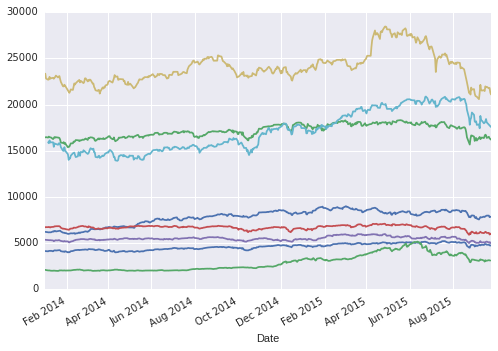

In [246]:
for data_frame in data_frames:
    data_frame['Adj Close'].plot()

In [247]:
for data_frame in data_frames:
    daily_return(data_frame)

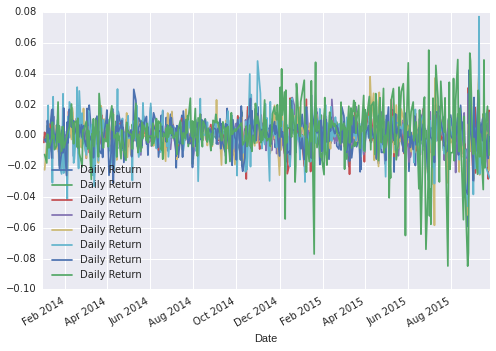

In [248]:
plot_data(data_frames, ['Daily Return'])

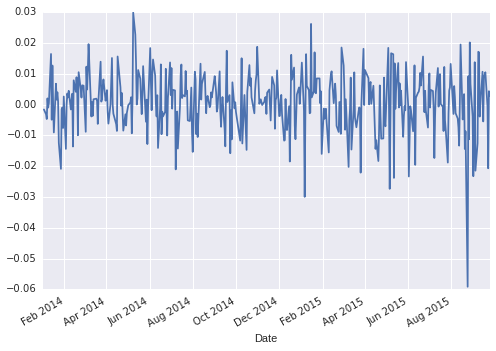

In [249]:
data_frames[0]['Daily Return'].plot()

In [250]:
data_frames[0].index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15', 
               ...
               '2015-09-10', '2015-09-11', '2015-09-14', '2015-09-15',
               '2015-09-16', '2015-09-18', '2015-09-21', '2015-09-22',
               '2015-09-23', '2015-09-24'],
              dtype='datetime64[ns]', name='Date', length=423, freq=None, tz=None)

In [251]:
for data_frame in data_frames:
    data_frame = get_moving_average(data_frame, [5,10,15,20])

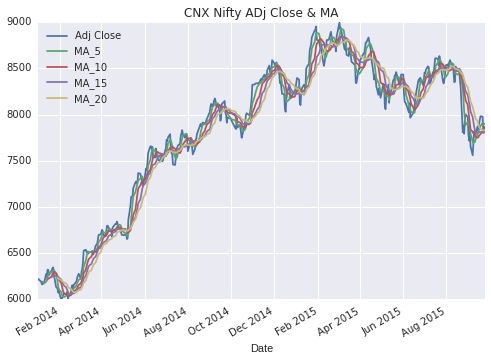

In [252]:
cols=['Adj Close','MA_5','MA_10','MA_15','MA_20']
for col in cols:
    data_frames[0][col].plot(legend=True)
    plt.title('CNX Nifty ADj Close & MA')

In [253]:
for data_frame in data_frames:
    data_frame = get_ewma(data_frame, [5,10,15,20])

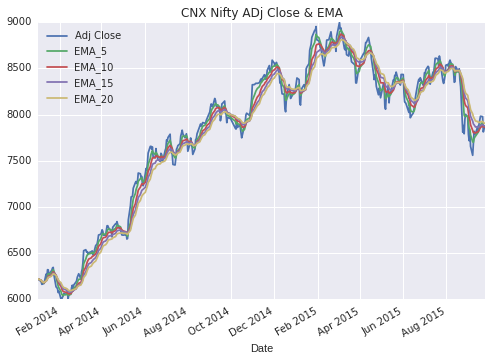

In [254]:
cols=['Adj Close','EMA_5','EMA_10','EMA_15','EMA_20']
for col in cols:
    data_frames[0][col].plot(legend=True)
    plt.title('CNX Nifty ADj Close & EMA')

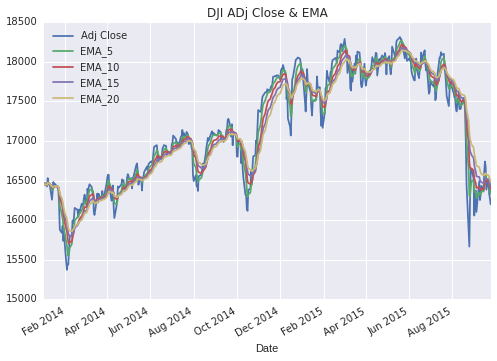

In [255]:
cols=['Adj Close','EMA_5','EMA_10','EMA_15','EMA_20']
for col in cols:
    data_frames[1][col].plot(legend=True)
    plt.title('DJI ADj Close & EMA')

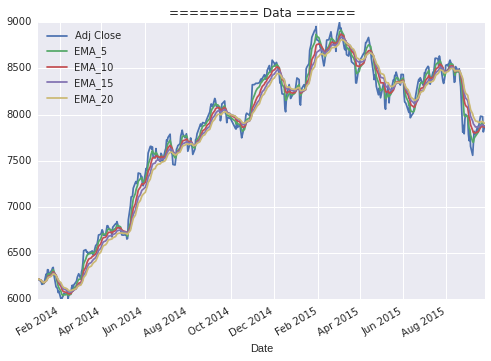

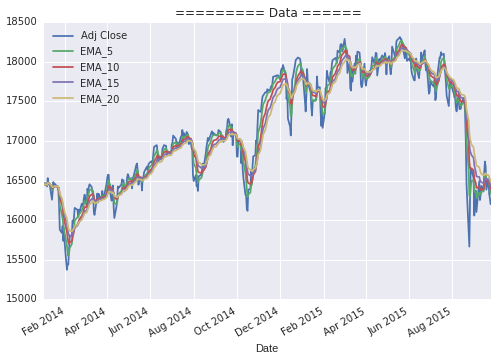

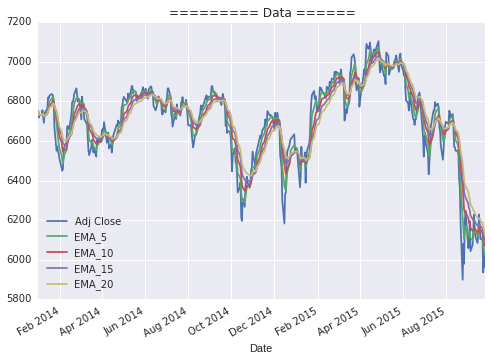

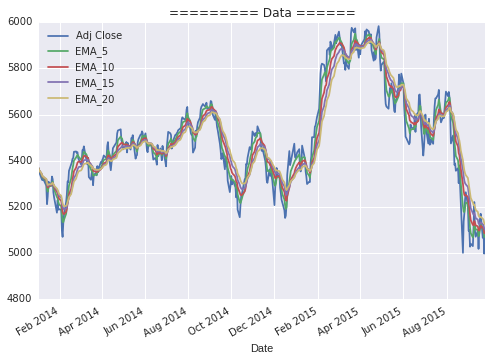

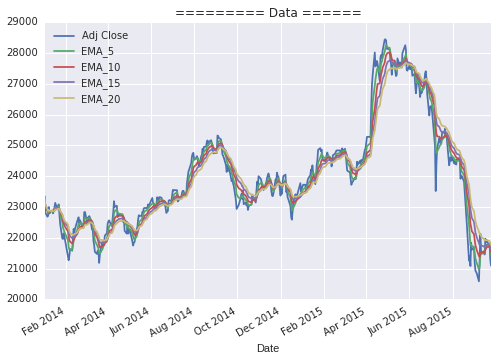

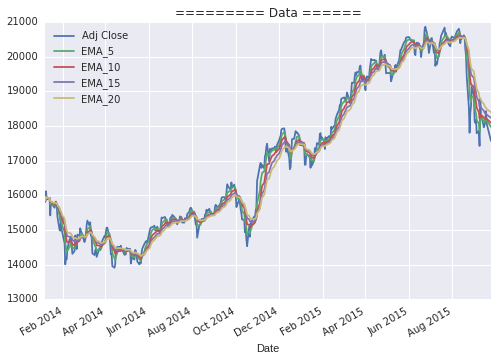

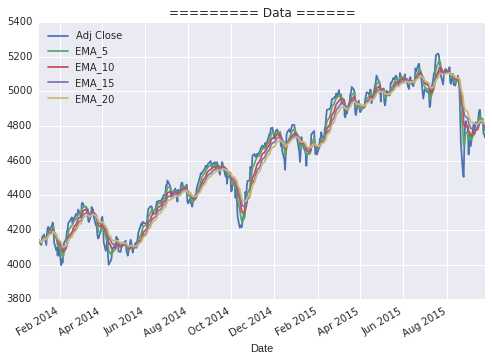

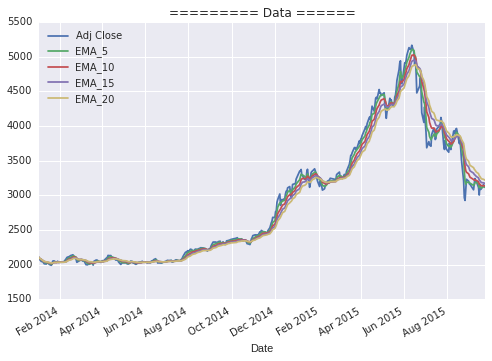

In [256]:
for data_frame in data_frames:
    data_frame=get_ewma(data_frame, [5,10,15,20])
plot_data(data_frames, ['Adj Close','EMA_5','EMA_10','EMA_15','EMA_20'])

In [257]:
renamme_columns(data_frames, market_name)

In [258]:
data_frames[1].index.name

'Date'

In [267]:
print(data_frames[1].columns)

Index(['Open_dji', 'High_dji', 'Low_dji', 'Close_dji', 'Volume_dji',
       'Adj Close_dji', 'Daily Return_dji', 'MA_5_dji', 'MA_10_dji',
       'MA_15_dji', 'MA_20_dji', 'EMA_5_dji', 'EMA_10_dji', 'EMA_15_dji',
       'EMA_20_dji'],
      dtype='object')


* Data point counts

In [271]:
for name, data_frame in zip(market_name, data_frames):
    print ("No of Data for [%8s] are [%s]"%(name,len(data_frame)))

No of Data for [     nse] are [423]
No of Data for [     dji] are [436]
No of Data for [    ftse] are [439]
No of Data for [     aus] are [440]
No of Data for [     hsi] are [430]
No of Data for [  nikkei] are [435]
No of Data for [  nasdaq] are [436]
No of Data for [ sanghai] are [420]


<b> Merge Data Frames </b>
<br/> We are interested in colums after Adjusted close.

In [326]:
merged_data = merge_data_frames(data_frames, 5)

In [331]:
print(merged_data.columns)

Index(['Adj Close_nse', 'Daily Return_nse', 'MA_5_nse', 'MA_10_nse',
       'MA_15_nse', 'MA_20_nse', 'EMA_5_nse', 'EMA_10_nse', 'EMA_15_nse',
       'EMA_20_nse', 'Adj Close_dji', 'Daily Return_dji', 'MA_5_dji',
       'MA_10_dji', 'MA_15_dji', 'MA_20_dji', 'EMA_5_dji', 'EMA_10_dji',
       'EMA_15_dji', 'EMA_20_dji', 'Adj Close_ftse', 'Daily Return_ftse',
       'MA_5_ftse', 'MA_10_ftse', 'MA_15_ftse', 'MA_20_ftse', 'EMA_5_ftse',
       'EMA_10_ftse', 'EMA_15_ftse', 'EMA_20_ftse', 'Adj Close_aus',
       'Daily Return_aus', 'MA_5_aus', 'MA_10_aus', 'MA_15_aus', 'MA_20_aus',
       'EMA_5_aus', 'EMA_10_aus', 'EMA_15_aus', 'EMA_20_aus', 'Adj Close_hsi',
       'Daily Return_hsi', 'MA_5_hsi', 'MA_10_hsi', 'MA_15_hsi', 'MA_20_hsi',
       'EMA_5_hsi', 'EMA_10_hsi', 'EMA_15_hsi', 'EMA_20_hsi',
       'Adj Close_nikkei', 'Daily Return_nikkei', 'MA_5_nikkei',
       'MA_10_nikkei', 'MA_15_nikkei', 'MA_20_nikkei', 'EMA_5_nikkei',
       'EMA_10_nikkei', 'EMA_15_nikkei', 'EMA_20_nikkei', 'Adj

In [332]:
merged_data.describe()

,Adj Close_nse,Daily Return_nse,MA_5_nse,MA_10_nse,MA_15_nse,MA_20_nse,EMA_5_nse,EMA_10_nse,EMA_15_nse,EMA_20_nse,...,Adj Close_sanghai,Daily Return_sanghai,MA_5_sanghai,MA_10_sanghai,MA_15_sanghai,MA_20_sanghai,EMA_5_sanghai,EMA_10_sanghai,EMA_15_sanghai,EMA_20_sanghai
count,423.000000,422.000000,419.000000,414.000000,409.000000,404.000000,423.000000,423.000000,423.000000,423.000000,...,420.000000,419.000000,416.000000,411.000000,406.000000,401.000000,420.000000,420.000000,420.000000,420.000000
mean,7809.766553,0.000602,7817.174277,7826.524956,7836.247641,7846.272727,7801.914954,7792.164680,7782.182102,7771.706559,...,2897.957143,0.001114,2900.802500,2904.750993,2908.657471,2912.677946,2893.007149,2886.508020,2879.441464,2871.683574
std,808.974555,0.009470,802.104855,793.458271,785.285995,777.162115,811.875159,816.390832,821.044959,825.608275,...,897.216227,0.018980,897.172382,896.974524,896.318921,895.566118,894.969405,892.217094,888.936046,885.018933
min,6000.899902,-0.059151,6024.919922,6037.420020,6057.146680,6075.990039,6042.132893,6059.836664,6078.528383,6092.961172,...,1991.250000,-0.084907,2004.272000,2013.306000,2023.890000,2025.760000,2008.778877,2016.181865,2020.558451,2023.196263
25%,7483.650147,-0.003852,7529.225098,7549.895117,7562.583398,7548.749432,7525.127748,7455.047821,7382.494015,7317.613216,...,2067.362500,-0.006192,2063.706500,2070.725500,2078.168167,2076.783000,2065.625243,2067.246055,2067.291502,2064.080789
50%,8027.600098,0.000848,8052.040039,8074.412573,8086.023405,8097.093762,8047.464660,8061.380729,8038.491721,8018.029773,...,2463.020000,0.001450,2466.242000,2462.765000,2459.899000,2468.157000,2460.594369,2441.057180,2422.462987,2408.302813
75%,8421.399903,0.006112,8422.990039,8433.208740,8433.840039,8430.598157,8420.271882,8411.791721,8394.360713,8387.129901,...,3591.032500,0.009291,3602.922000,3598.300500,3593.245833,3588.909000,3555.115349,3530.453134,3509.209920,3507.003672
max,8996.250000,0.029873,8931.600000,8845.974902,8839.716536,8807.152392,8913.929201,8870.787918,8838.603612,8809.378302,...,5166.350000,0.055314,5127.878000,5052.791000,4971.617333,4925.927000,5107.789023,5028.316114,4951.379227,4887.240400


<b> Count missing data(NaN) after simple merge</b>
* Fill the missing data.

In [344]:
print("Shape of merged data",merged_data.shape,".")
print("After merge out of [",len(merged_data)*len(merged_data.columns),"] [",count_missing(merged_data),"] data points are missing.")

Shape of merged data (451, 80) .
After merge out of [ 36080 ] [ 1866 ] data points are missing.


In [346]:
merged_data = merged_data.interpolate(method='time')
print ('Number of NaN after time interpolation: %s' % str(count_missing(merged_data)))

Number of NaN after time interpolation: 471


In [347]:
merged_data = merged_data.fillna(merged_data.mean())
print ('Number of NaN after mean interpolation: %s' %count_missing(merged_data)) 

Number of NaN after mean interpolation: 0


* Prepare data for classification.

In [350]:
X_train, y_train, X_test, y_test = prepare_data_for_classification(merged_data, '2015-08-01')

In [353]:
print ("======== Shapes ======== ")
print ("Training X",X_train.shape)
print ("Training y",y_train.shape)
print ("Test     X",X_test.shape)
print ("Test     y",y_test.shape)
print ("======================== ")


======== Shapes ======== 
Training X (412, 79)
Training y (412,)
Test     X (39, 79)
Test     y (39,)


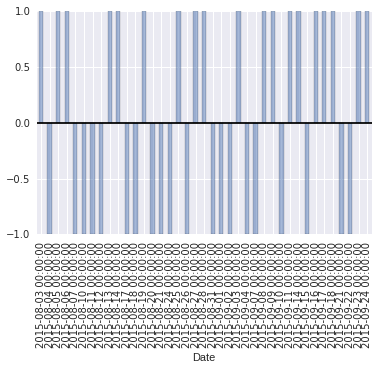

In [373]:
plt.figure()
y_test.plot(kind='bar', alpha=0.5)
plt.axhline(0, color='k')

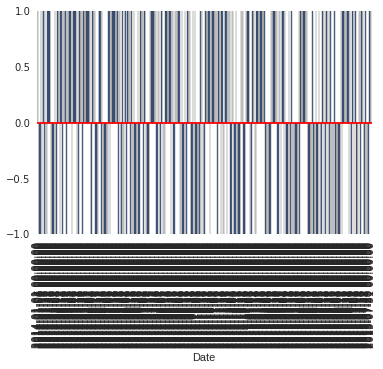

In [377]:
plt.figure()
y_train.plot(kind='bar', alpha=0.9)
plt.axhline(0, color='r')

In [381]:
print ("Postive and negative movement in train data outcome.")
print (y_train.value_counts())
print ("Postive and negative movement in test data outcome.")
print (y_test.value_counts())

Postive and negative movement in train data outcome.
 1    229
-1    183
dtype: int64
Postive and negative movement in test data outcome.
-1    20
 1    19
dtype: int64


Data points are evenly distributed.

* Finally done with data cleaning. Now time to apply some machine learning.